In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

# pandasの行列を省略しない
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [11]:
train_df = pd.read_csv("V:/kobayashi_kaggle/jLeague/train.csv")
venue_df = pd.read_csv("V:/kobayashi_kaggle/jLeague/venue_information.csv")
match_df = pd.read_csv("V:/kobayashi_kaggle/jLeague/match_reports.csv")
holidays_df = pd.read_csv("V:/kobayashi_kaggle/jLeague/holidays_in_japan.csv")

In [12]:
train_df.head()

,id,match_date,kick_off_time,section,round,home_team,away_team,venue,weather,temperature,humidity,broadcasters,attendance
0,9190,2006-03-04,16:04,第1節,第1日,G大阪,浦和,万博記念競技場,晴,8.3,40,NHK総合/J SPORTS(録),20916
1,9191,2006-03-05,13:00,第1節,第2日,甲府,清水,山梨県小瀬スポーツ公園陸上競技場,晴,12.9,28,山梨放送/テレビ静岡(録)/J SPORTS(録),14277
2,9192,2006-03-05,13:35,第1節,第2日,FC東京,大分,味の素スタジアム,晴,12.1,35,BS-i/MXテレビ(録)/J SPORTS(録),22531
3,9193,2006-03-05,14:04,第1節,第2日,磐田,福岡,静岡スタジアムエコパ,晴,11.6,42,J SPORTS,28564
4,9194,2006-03-05,14:04,第1節,第2日,名古屋,C大阪,名古屋市瑞穂陸上競技場,晴,13.1,32,スカイパーフェクTV!/NHK名古屋(録)/NHK大阪(録)/J SPORTS(録),17199


In [13]:
def clean(df):
    # 祝日の付与
    holidays_df.rename(columns={'holiday_date': 'match_date'}, inplace=True)
    holidays_df['holiday_flag'] = 1
    df = pd.merge(df, holidays_df, on='match_date', how='left')
    df['holiday_flag'] = df['holiday_flag'].fillna(0)

    # match_dateの日付型に変換
    df['match_date'] = pd.to_datetime(df['match_date'])
    df['year'] = df['match_date'].dt.year
    df['month'] = df['match_date'].dt.month
    df['day'] = df['match_date'].dt.day
    df['day_name'] = df['match_date'].dt.weekday

    # kickoff_timeの時間型に変換
    df['kick_off_time'] = pd.to_datetime(df['kick_off_time'], format='%H:%M')
    df['kick_off_time'] = df['kick_off_time'].dt.hour + df['kick_off_time'].dt.minute / 60

    # sectionの数値化
    df['section'] = df['section'].str.replace('第', '').str.replace('節', '').astype(int)

    # roundの数値化
    df['round'] = df['round'].str.replace('第', '').str.replace('日', '').astype(int)

    # 雨の付与
    df['rain'] = 0
    df.loc[df['weather'].str.contains('雨'), 'rain'] = 1

    # 晴れの付与
    df['sunny'] = 0
    df.loc[df['weather'].str.contains('晴'), 'sunny'] = 1

    # NHKの付与
    df['nhk'] = 0
    df.loc[df['broadcasters'].str.contains('NHK'), 'nhk'] = 1

    # broadcastersの数値化
    df['broadcasters'] = df['broadcasters'].str.count('/') + 1

    # homeとawayの距離
    
    
    # venueの結合
    df = pd.merge(df, venue_df, on='venue', how='left')

    return df

train_clean = clean(train_df)
train_clean.head()


,id,match_date,kick_off_time,section,round,home_team,away_team,venue,weather,temperature,humidity,broadcasters,attendance,description,holiday_flag,year,month,day,day_name,rain,sunny,nhk,capacity,address
0,9190,2006-03-04,16.066667,1,1,G大阪,浦和,万博記念競技場,晴,8.3,40,2,20916,NaN,0.0,2006,3,4,5,0,1,1,21000,大阪府吹田市千里万博公園5-2
1,9191,2006-03-05,13.000000,1,2,甲府,清水,山梨県小瀬スポーツ公園陸上競技場,晴,12.9,28,3,14277,NaN,0.0,2006,3,5,6,0,1,0,15859,山梨県甲府市小瀬町840
2,9192,2006-03-05,13.583333,1,2,FC東京,大分,味の素スタジアム,晴,12.1,35,3,22531,NaN,0.0,2006,3,5,6,0,1,0,47851,東京都調布市西町376−3
3,9193,2006-03-05,14.066667,1,2,磐田,福岡,静岡スタジアムエコパ,晴,11.6,42,1,28564,NaN,0.0,2006,3,5,6,0,1,0,51697,静岡県袋井市愛野2300−1
4,9194,2006-03-05,14.066667,1,2,名古屋,C大阪,名古屋市瑞穂陸上競技場,晴,13.1,32,4,17199,NaN,0.0,2006,3,5,6,0,1,1,20223,愛知県名古屋市瑞穂区山下通5-1


### capacityは明らかに関係あるが、他に目立った関係無し

<AxesSubplot:>

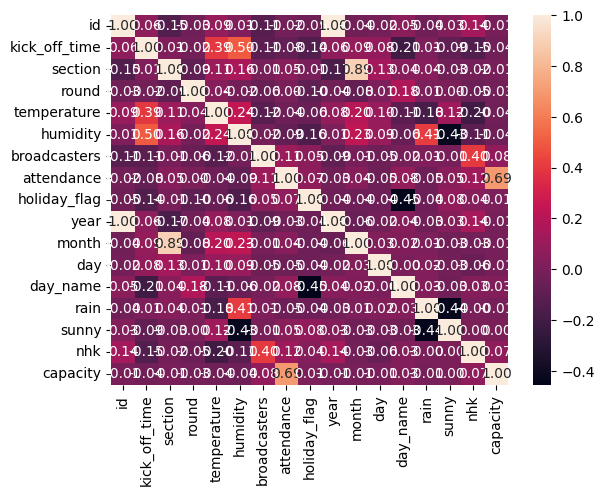

In [14]:
numerical_df = train_clean.select_dtypes(include=[np.number])
sns.heatmap(numerical_df.corr(), annot=True, fmt='.2f')

### sectionによるばらつきは、最初と最後以外はノイズっぽい

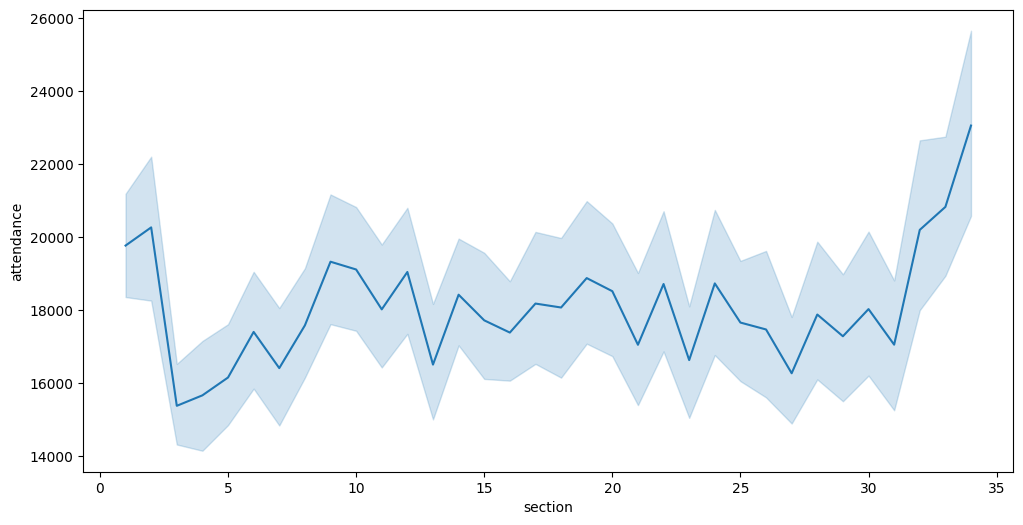

In [17]:
# sectionごとの平均attendanceをplot
plt.figure(figsize=(12, 6))
sns.lineplot(x='section', y='attendance', data=train_clean)
plt.show()


### 気温は関係なさそう

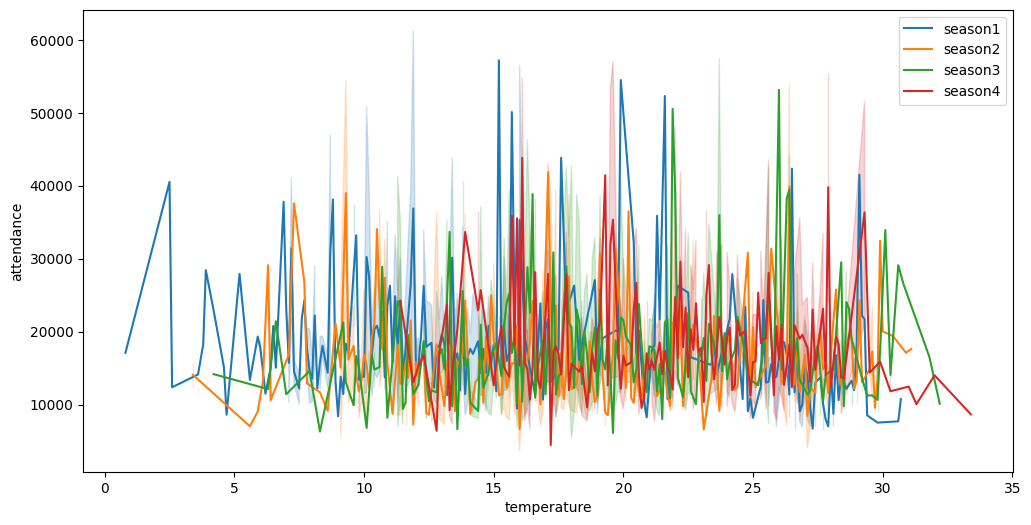

In [26]:
# sectionごとの平均attendanceをplot
plt.figure(figsize=(12, 6))
for i in range(4):
    season_list = [i*3+1, i*3+2, i*3+3]
    sns.lineplot(x='temperature', y='attendance', data=train_clean[train_clean['section'].isin(season_list)], label=f'season{i+1}')
    # sns.lineplot(x='temperature', y='attendance', data=train_clean[train_clean['month'] in season_list], label=f'season{i+1}')
plt.show()

### 2011年の震災によるイレギュラーが悪影響与えているかも

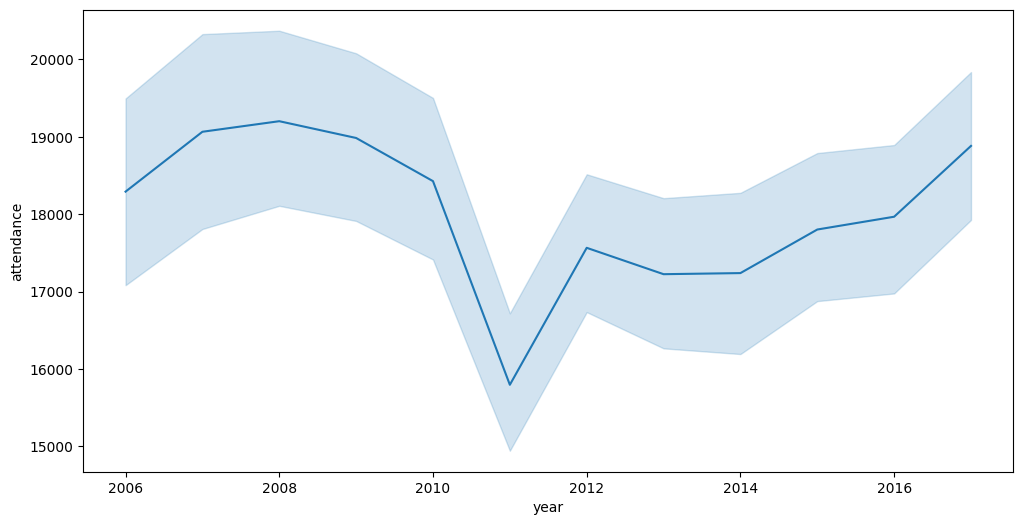

In [18]:
# sectionごとの平均attendanceをplot
plt.figure(figsize=(12, 6))
sns.lineplot(x='year', y='attendance', data=train_clean)
plt.show()

(array([  17.,   86.,  332.,   57.,   55., 2342.,  783.]),
 array([0.        , 0.85714286, 1.71428571, 2.57142857, 3.42857143,
        4.28571429, 5.14285714, 6.        ]),
 <BarContainer object of 7 artists>)

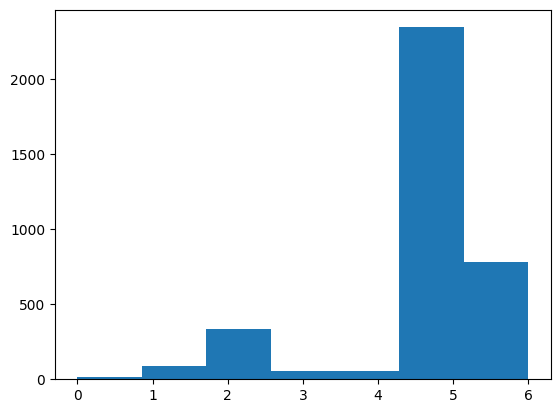

In [30]:
plt.hist(train_clean[['day_name']], bins=7)

### ダービー戦は盛り上がりそう

In [31]:
train_clean.head()

,id,match_date,kick_off_time,section,round,home_team,away_team,venue,weather,temperature,humidity,broadcasters,attendance,description,holiday_flag,year,month,day,day_name,rain,sunny,nhk,capacity,address
0,9190,2006-03-04,16.066667,1,1,G大阪,浦和,万博記念競技場,晴,8.3,40,2,20916,NaN,0.0,2006,3,4,5,0,1,1,21000,大阪府吹田市千里万博公園5-2
1,9191,2006-03-05,13.000000,1,2,甲府,清水,山梨県小瀬スポーツ公園陸上競技場,晴,12.9,28,3,14277,NaN,0.0,2006,3,5,6,0,1,0,15859,山梨県甲府市小瀬町840
2,9192,2006-03-05,13.583333,1,2,FC東京,大分,味の素スタジアム,晴,12.1,35,3,22531,NaN,0.0,2006,3,5,6,0,1,0,47851,東京都調布市西町376−3
3,9193,2006-03-05,14.066667,1,2,磐田,福岡,静岡スタジアムエコパ,晴,11.6,42,1,28564,NaN,0.0,2006,3,5,6,0,1,0,51697,静岡県袋井市愛野2300−1
4,9194,2006-03-05,14.066667,1,2,名古屋,C大阪,名古屋市瑞穂陸上競技場,晴,13.1,32,4,17199,NaN,0.0,2006,3,5,6,0,1,1,20223,愛知県名古屋市瑞穂区山下通5-1


###  表記揺れあるやんけ

In [42]:
train_clean['home_team'].unique() 

array(['G大阪', '甲府', 'FC東京', '磐田', '名古屋', '大宮', '川崎F', '広島', '横浜FM', '浦和',
       '千葉', '新潟', '清水', '鹿島', '京都', '福岡', '大分', 'C大阪', '柏', '横浜FC', '神戸',
       '札幌', '東京V', '山形', '湘南', '仙台', '鳥栖', '徳島', '松本', 'Ｃ大阪', 'Ｇ大阪',
       '川崎Ｆ'], dtype=object)

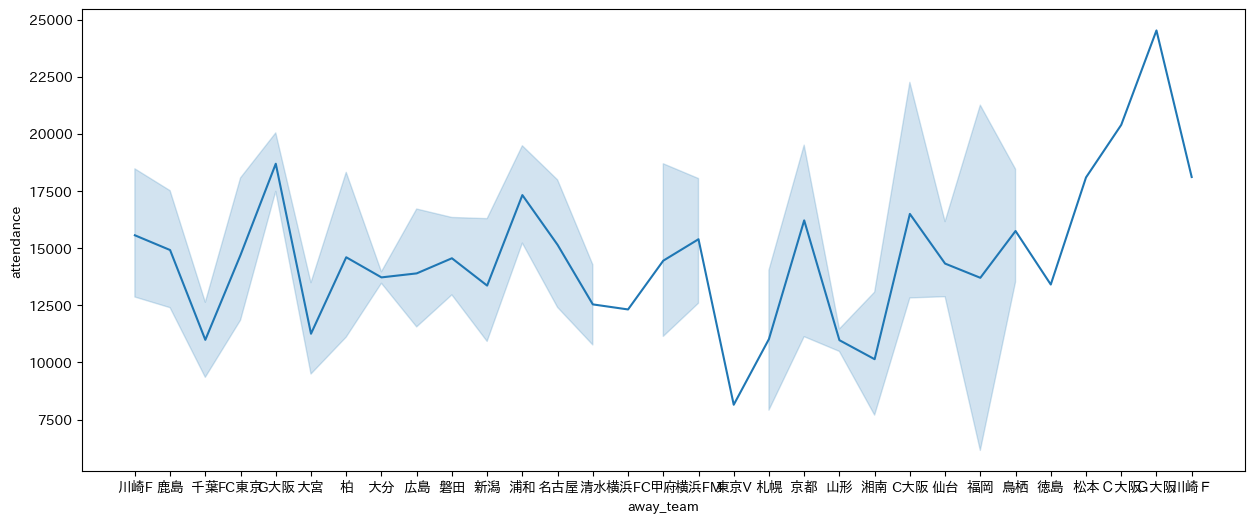

In [40]:
oosaka_df = train_clean[train_clean['home_team'] == '神戸']
plt.figure(figsize=(15, 6))
sns.lineplot(x='away_team', y='attendance', data=oosaka_df)
plt.show()


In [ ]:
holidays_df.rename(columns={'holiday_date': 'match_date'}, inplace=True)
holidays_df['holiday_flg'] = 1
train_df = pd.merge(train_df, holidays_df, on='match_date', how='left')
train_df['holiday_flg'] = train_df['holiday_flg'].fillna(0)
train_df.drop('description', axis=1, inplace=True)
train_df.head()

In [33]:
# trainの欠損値等の確認

# 欠損値なし
print(train_df.isnull().sum())

# ユニーク
home_teams = train_df['home_team'].unique()
away_teams = train_df['away_team'].unique()

# home_teamとaway_teamのユニークの差分もなし
print(np.setdiff1d(home_teams, away_teams))

print(train_df['section'].unique())
print(train_df['venue'].nunique())

print(train_df['weather'].unique())
print(train_df['broadcasters'].nunique())


id               0
match_date       0
kick_off_time    0
section          0
round            0
home_team        0
away_team        0
venue            0
weather          0
temperature      0
humidity         0
broadcasters     0
attendance       0
dtype: int64
[]
['第1節' '第2節' '第3節' '第4節' '第5節' '第6節' '第7節' '第8節' '第9節' '第10節' '第11節'
 '第12節' '第13節' '第14節' '第15節' '第16節' '第17節' '第18節' '第19節' '第20節' '第21節'
 '第22節' '第23節' '第24節' '第25節' '第26節' '第27節' '第28節' '第29節' '第30節' '第31節'
 '第32節' '第33節' '第34節']
60
['晴' '曇' '屋内' '曇時々晴' '雨' '曇のち雨' '晴一時雨' '晴時々曇' '晴のち曇' '曇一時雨' '雨のち曇' '雨一時曇'
 '曇のち雨のち屋内' '曇時々晴のち屋内' '曇のち晴' '曇時々雨' '雨のち曇時々雨' '曇時々雪' '晴一時曇' '雨時々曇'
 '曇一時雨のち曇' '曇のち雨一時雷' '晴時々曇一時雨' '霧' '雷雨のち曇' '曇一時雷雨のち雨' '晴一時雨のち曇' '曇のち雷雨'
 '雨一時曇のち雨' '雪' '雨のち曇のち晴' '晴のち雨' '曇一時晴' '曇一時雨のち晴' '雨のち晴' '晴のち曇一時雨'
 '曇一時雷雨のち曇' '晴時々雪' '雨時々晴' '曇時々雨のち晴' '曇時々晴一時雨' '雨のち曇一時雨' '晴のち雪' '雨一時雷雨'
 '曇のち雨のち曇' '曇のち雨のち晴' '曇晴' '曇のち霧' '雨のち曇のち雨']
659


## スタジアム情報
- 試合情報の会場ユニークは60に対して、会場情報には120データがある。そのうち住所のユニークは87
- 住所重複は名前変更によるもののようである
- 住所ユニークが多いのは、住所変更と表記揺れ

In [49]:
venue_df_sorted = venue_df.sort_values('address', ascending=False)
venue_df_sorted.head()

,venue,capacity,address
38,白波スタジアム,12606,鹿児島県鹿児島市与次郎2丁目2−2
112,鹿児島県立鴨池陸上競技場,12584,鹿児島県鹿児島市与次郎2丁目2−2
45,Axisバードスタジアム,11999,鳥取県鳥取市蔵田423
55,Pikaraスタジアム,22338,香川県丸亀市金倉町830
100,日本平スタジアム,20248,静岡県静岡市清水区村松3880−1


In [44]:
# venueの確認

print (venue_df.isnull().sum())
print(len(venue_df))
print(venue_df['address'].nunique())
print(venue_df['venue'].nunique())
venue_df

venue       0
capacity    0
address     0
dtype: int64
120
87
120


,venue,capacity,address
0,札幌ドーム,38794,北海道札幌市豊平区羊ヶ丘1
1,埼玉スタジアム2002,62010,埼玉県さいたま市緑区中野田500
2,味の素スタジアム,47851,東京都調布市西町376−3
3,町田GIONスタジアム,15320,東京都町田市野津田町2035
4,日産スタジアム,71624,神奈川県横浜市港北区小机町3300
...,...,...,...
115,宮城スタジアム,49133,宮城県宮城郡利府町菅谷字舘40-1
116,コカ・コーラウエスト広島スタジアム,13800,広島県広島市西区観音新町2丁目11−124
117,佐賀県総合運動場陸上競技場,17000,佐賀県佐賀市日の出2-1-10
118,ShonanBMWスタジアム平塚,15732,神奈川県平塚市大原1−1


In [6]:
match_df.head()

,id,home_team_player11,home_team_player10,home_team_player9,home_team_player8,home_team_player7,home_team_player6,home_team_player5,home_team_player4,home_team_player3,...,away_team_player2,away_team_player3,away_team_player4,away_team_player5,away_team_player6,away_team_player7,away_team_player8,away_team_player9,away_team_player10,away_team_player11
0,9190,9 マグノアウベス FW,8 フェルナンジーニョ FW,10 二川孝広 MF,7 遠藤保仁 MF,27 橋本英郎 MF,17 明神智和 MF,14 家長昭博 DF,6 山口智 DF,2 シジクレイ DF,...,2 坪井慶介 DF,4 田中マルクス闘莉王 DF,20 堀之内聖 DF,6 山田暢久 MF,17 長谷部誠 MF,13 鈴木啓太 MF,8 三都主アレサンドロ MF,18 小野伸二 MF,10 ポンテ FW,21 ワシントン FW
1,9191,18 長谷川太郎 FW,16 バレー FW,11 宇留野純 FW,31 林健太郎 MF,25 鈴木健太 MF,8 倉貫一毅 MF,4 山本英臣 DF,20 ビジュ DF,15 アライール DF,...,25 市川大祐 DF,26 青山直晃 DF,4 高木和道 DF,3 山西尊裕 DF,13 兵働昭弘 MF,7 伊東輝悦 MF,16 枝村匠馬 MF,10 藤本淳吾 MF,18 チョジェジン FW,17 マルキーニョス FW
2,9192,9 ルーカス FW,21 サササルセード FW,35 リチェーリ FW,6 今野泰幸 MF,23 梶山陽平 MF,19 伊野波雅彦 MF,15 鈴木規郎 DF,5 増嶋竜也 DF,2 茂庭照幸 DF,...,2 三木隆司 DF,4 深谷友基 DF,22 上本大海 DF,5 エジミウソン MF,11 トゥーリオ MF,6 梅田高志 MF,17 根本裕一 MF,26 内村圭宏 MF,13 高松大樹 FW,9 オズマール FW
3,9193,15 西野泰正 FW,22 カレンロバート FW,7 名波浩 MF,14 村井慎二 MF,23 福西崇史 MF,25 ファブリシオ MF,11 西紀寛 MF,6 服部年宏 DF,5 田中誠 DF,...,22 中村北斗 DF,4 金古聖司 DF,5 千代反田充 DF,3 アレックス DF,7 宮崎光平 MF,6 布部陽功 MF,8 ホベルト MF,14 古賀誠史 MF,27 田中佑昌 FW,36 グラウシオ FW
4,9194,19 杉本恵太 FW,11 玉田圭司 FW,27 片山奨典 MF,7 中村直志 MF,14 吉村圭司 MF,8 金正友 MF,6 有村光史 DF,29 深津康太 DF,5 古賀正紘 DF,...,2 ブルーノクアドロス DF,5 前田和哉 DF,3 柳本啓成 DF,4 河村崇大 MF,23 下村東美 MF,10 ピンゴ MF,6 ゼカルロス MF,8 森島寛晃 FW,20 西澤明訓 FW,9 古橋達弥 FW


In [7]:
holidays_df.head()

,holiday_date,description
0,2006-01-01,元日
1,2006-01-02,元日 振替休日
2,2006-01-09,成人の日
3,2006-02-11,建国記念の日
4,2006-03-21,春分の日
